## Import Library

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import sklearn
import imblearn
import warnings
import sys

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold = sys.maxsize)
np.set_printoptions(precision = 3)
sns.set(style = "darkgrid")
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v, round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))

def analyze(filename):
    print()
    print("Analyzing: {}".format(filename))
    df = pd.read_csv(filename, encoding = 'utf-8')
    cols = df.columns.values
    total = float(len(df))
    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col, unique_count ,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col, expand_categories(df[col])))
            expand_categories(df[col])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Memuat Data

In [0]:
datatrain = '/content/gdrive/My Drive/Colab Notebooks/ddoscicids2017.csv'
datatest = '/content/gdrive/My Drive/Colab Notebooks/ddosattacksimulationfix_manual.csv'
#analyze(datatest)

In [4]:
col_names = [
    'flow_id','source_ip','source_port','destination_ip','destination_port','protocol','timestamp','flow_duration',
    'total_fwd_packets','total_bwd_packets','total_length_of_fwd_packets','total_length_of_bwd_packets',
    'fwd_packet_length_max','fwd_packet_length_min','fwd_packet_length_mean','fwd_packet_length_std',
    'bwd_packet_length_max','bwd_packet_length_min','bwd_packet_length_mean','bwd_packet_length_std',
    'flow_bytes','flow_packets','flow_iat_mean','flow_iat_std','flow_iat_max','flow_iat_min',
    'fwd_iat_total','fwd_iat_mean','fwd_iat_std','fwd_iat_max','fwd_iat_min','bwd_iat_total','bwd_iat_mean',
    'bwd_iat_std','bwd_iat_max','bwd_iat_min','fwd_psh_flags','bwd_psh_flags','fwd_urg_flags','bwd_urg_flags',
    'fwd_header_length','bwd_header_length','fwd_packets','bwd_packets','min_packet_length','max_packet_length',
    'packet_length_mean','packet_length_std','packet_length_variance','fin_flag_count','syn_flag_count',
    'rst_flag_count','psh_flag_count','ack_flag_count','urg_flag_count','cwe_flag_count','ece_flag_count',
    'down_up_ratio','average_packet_size','avg_fwd_segment_size','avg_bwd_segment_size','fwd_avg_bytes_bulk',
    'fwd_avg_packets_bulk','fwd_avg_bulk_rate','bwd_avg_bytes_bulk','bwd_avg_packets_bulk','bwd_avg_bulk_rate',
    'subflow_fwd_packets','subflow_fwd_bytes','subflow_bwd_packets','subflow_bwd_bytes','init_win_bytes_forward',
    'init_win_bytes_backward','act_data_pkt_fwd','min_seg_size_forward','active_mean','active_std','active_max',
    'active_min','idle_mean','idle_std','idle_max','idle_min','label'
]

df_train = pd.read_csv(datatrain, names = col_names, skiprows = 1)
df_test = pd.read_csv(datatest, names = col_names, skiprows = 1)

print('Dimensi Data Latih:', df_train.shape)
print('Dimensi Data Uji:', df_test.shape)

Dimensi Data Latih: (225745, 84)
Dimensi Data Uji: (5926, 84)


In [5]:
df_train.head()

,flow_id,source_ip,source_port,destination_ip,destination_port,protocol,timestamp,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_avg_bytes_bulk,fwd_avg_packets_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_bulk,bwd_avg_packets_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4000000,666666.6667,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,110091.7431,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,230769.2308,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,352941.1765,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4000000,666666.6667,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
df_test.head()

,flow_id,source_ip,source_port,destination_ip,destination_port,protocol,timestamp,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_avg_bytes_bulk,fwd_avg_packets_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_bulk,bwd_avg_packets_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,192.168.60.1-192.168.60.3-51165-80-6,192.168.60.3,80,192.168.60.1,51165,6,6/7/2019 21:30,38,0,2,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,52631.578950,38.0,0.0,38.0,38.0,0.0,0.0,0.0,0.0,0.0,38.0,38.0,0.0,38.0,38,0,0,0,0,0,40,0.000000,52631.578950,0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2,0,-1,2053,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.60.1-224.0.0.252-52305-5355-17,192.168.60.1,52305,224.0.0.252,5355,17,6/7/2019 21:32,409783,1,1,22,22,22,22,22.0,0.0,22,22,22.0,0.0,107.373903,4.880632,409783.0,0.0,409783.0,409783.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,8,8,2.440316,2.440316,22,22,22.0,0.0,0.0,0,0,0,0,0,0,0,0,1,33.0,22.0,22.0,0,0,0,0,0,0,1,22,1,22,-1,-1,1,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.60.1-192.168.60.3-51192-80-6,192.168.60.3,80,192.168.60.1,51192,6,6/7/2019 21:31,34,0,2,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,58823.529410,34.0,0.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,34.0,34.0,0.0,34.0,34,0,0,0,0,0,40,0.000000,58823.529410,0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2,0,-1,2048,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.60.1-192.168.60.3-51168-80-6,192.168.60.3,80,192.168.60.1,51168,6,6/7/2019 21:30,36,0,2,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,55555.555560,36.0,0.0,36.0,36.0,0.0,0.0,0.0,0.0,0.0,36.0,36.0,0.0,36.0,36,0,0,0,0,0,40,0.000000,55555.555560,0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2,0,-1,2053,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.60.1-192.168.60.3-51184-80-6,192.168.60.3,80,192.168.60.1,51184,6,6/7/2019 21:31,43,0,2,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,46511.627910,43.0,0.0,43.0,43.0,0.0,0.0,0.0,0.0,0.0,43.0,43.0,0.0,43.0,43,0,0,0,0,0,40,0.000000,46511.627910,0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2,0,-1,2053,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BENIGN


## Praproses Data

### Explorasi Data

In [7]:
df_train.describe()

,source_port,destination_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_avg_bytes_bulk,fwd_avg_packets_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_bulk,bwd_avg_packets_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,225745.000000,225745.00000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,225745.000000,225745.0,225745.0,225745.0,225745.000000,225745.000000,2.257450e+05,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.0,225745.0,225745.0,225745.0,225745.0,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,38257.568402,8879.61946,7.600288,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,2735.585147,16.718776,890.536849,1230.172938,1.580587e+06,4.248569e+06,1.348977e+07,2.811855e+04,1.539652e+07,2.540610e+06,5.195207e+06,1.299434e+07,2.073698e+05,6.564701e+06,9.476322e+05,1.610306e+06,4.567514e+06,2.257817e+05,0.033223,0.0,0.0,0.0,111.522718,106.789023,1.261508e+04,1.641693e+03,8.072595,3226.045339,515.002137,1085.593207,2.789906e+06,0.002671,0.033223,0.000120,0.351162,0.504463,0.140752,0.0,0.000120,1.005821,574.568843,164.826715,890.536849,0.0,0.0,0.0,0.0,0.0,0.0,4.874916,939.463346,4.572775,5.960477e+03,4247.436922,601.048635,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,23057.302075,19754.64740,3.881586,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,3705.123460,50.480568,1120.324921,1733.201267,2.701596e+06,7.622819e+06,2.670172e+07,7.598100e+05,3.160826e+07,5.934694e+06,1.078635e+07,2.748870e+07,3.795228e+06,2.198455e+07,4.586374e+06,5.475778e+06,1.617865e+07,4.019290e+06,0.179220,0.0,0.0,0.0,375.790727,511.765795,1.106701e+05,1.989593e+04,15.767713,3813.134850,559.064495,1269.558714,4.115941e+06,0.051614,0.179220,0.010936,0.477334,0.499981,0.347766,0.0,0.010936,1.430781,626.096202,504.892965,1120.324921,0.0,0.0,0.0,0.0,0.0,0.0,15.422874,3249.403484,21.755356,3.921834e+04,8037.781019,4319.720339,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.000000,0.00000,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0

In [8]:
df_test.describe()

,source_port,destination_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_avg_bytes_bulk,fwd_avg_packets_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_bulk,bwd_avg_packets_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,5926.000000,5926.000000,5926.000000,5.926000e+03,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5926.0,5926.000000,5926.0,5926.0,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.0,5926.000000,5926.000000,5926.0,5926.0,5926.0,5926.000000,5926.000000,5926.000000,5926.000000,5926.0,5926.0,5926.0,5926.0,5926.0,5926.0,5926.000000,5926.000000,5926.000000,5926.000000,5926.0,5926.000000,5926.000000,5926.0,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03,5.926000e+03
mean,48600.502700,9208.431151,6.079987,8.216515e+06,44.502194,1.935707,527.431488,247.932670,4.889470,0.625211,1.375855,1.596562,10.830577,0.625211,5.934842,4.403201,107.214085,4598.940326,3.324280e+06,2.545599e+06,5.578752e+06,1.495349e+06,3.937953e+06,3.426754e+06,1.676463e+05,3.582322e+06,3.305945e+06,3.539160e+06,1.312015e+06,1.510084e+06,2.525642e+06,7.818104e+03,0.0,0.000337,0.0,0.0,386.866689,50.851839,291.185542,4307.754784,0.625211,10.832265,3.997089,4.280077,2490.783806,0.243166,0.696254,0.0,0.000337,0.375802,0.0,0.0,0.0,0.391495,4.276273,1.375855,5.934842,0.0,0.0,0.0,0.0,0.0,0.0,44.502194,527.431488,1.935707,247.932670,-1.0,32555.466419,43.056024,0.0,1.560410e+06,1.093319e+04,1.569361e+06,1.553033e+06,4.053513e+06,1.506463e+05,4.192694e+06,3.932574e+06
std,21627.892509,21146.795653,1.014169,1.181130e+07,815.368133,6.947476,9785.775434,7282.339879,50.346004,14.056802,17.075171,18.478920,117.577174,14.056802,69.308908,50.791614,2895.478935,12962.648181,3.790037e+06,4.968768e+06,8.138860e+06,1.527737e+06,5.401055e+06,3.700776e+06,1.438899e+06,4.243653e+06,3.454428e+06,1.211245e+07,4.374672e+06,5.212726e+06,8.358381e+06,1.842208e+05,0.0,0.018370,0.0,0.0,6521.713601,140.890695,1098.872136,12835.363164,14.056802,117.583102,44.716693,49.728081,31529.200507,0.429031,0.459913,0.0,0.018370,0.484370,0.0,0.0,0.0,0.853460,46.888177,17.075171,69.308908,0.0,0.0,0.0,0.0,0.0,0.0,815.368133,9785.775434,6.947476,7282.339879,0.0,31338.702991,815.435917,0.0,1.519397e+06,1.710977e+05,1.527223e+06,1.522333e+06,5.267682e+06,1.133177e+06,5.650243e+06,5.094982e+06
min,0.000000,0.000000,0.000000,1.300000e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034482,1.300000e+01,0.000000e+00,1.300000e+01,7.000000e+00,0.00000

In [9]:
label_freq_train = df_train[['label']].apply(lambda x: x.value_counts())
label_freq_test = df_test[['label']].apply(lambda x: x.value_counts())
label_freq_train['freq_train_percent'] = round((100 * label_freq_train / label_freq_train.sum()), 2)
label_freq_test['freq_test_percent'] = round((100 * label_freq_test / label_freq_test.sum()), 2)

label_dist = pd.concat([label_freq_train,label_freq_test], axis = 1) 
label_dist

,label,freq_train_percent,label,freq_test_percent
DDoS,128027,56.71,3147,53.1
BENIGN,97718,43.29,2779,46.9


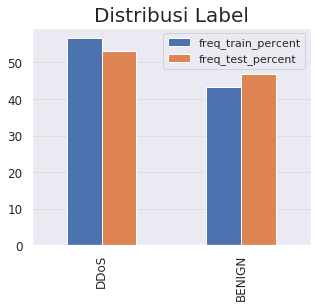

In [10]:
distplot = label_dist[['freq_train_percent','freq_test_percent']].plot(kind = 'bar', figsize = (5,4))
distplot.set_title('Distribusi Label', fontsize = 20)
distplot.grid(color = 'lightgray', alpha = 0.5)

### Pembersihan Data

In [0]:
df_train.drop([
    'fwd_urg_flags','bwd_urg_flags','cwe_flag_count','fwd_avg_bytes_bulk','fwd_avg_packets_bulk','fwd_avg_bulk_rate',
    'bwd_avg_bytes_bulk','bwd_avg_packets_bulk','bwd_avg_bulk_rate'], axis=1, inplace=True)
df_test.drop([
    'fwd_urg_flags','bwd_urg_flags','cwe_flag_count','fwd_avg_bytes_bulk','fwd_avg_packets_bulk','fwd_avg_bulk_rate',
    'bwd_avg_bytes_bulk','bwd_avg_packets_bulk','bwd_avg_bulk_rate'], axis=1, inplace=True)

In [0]:
df_train.drop(['flow_id','source_ip','source_port','destination_ip','timestamp'], inplace = True, axis = 1)
df_test.drop(['flow_id','source_ip','source_port','destination_ip','timestamp'], inplace = True, axis = 1)

In [13]:
df_train.isna().any()

destination_port               False
protocol                       False
flow_duration                  False
total_fwd_packets              False
total_bwd_packets              False
total_length_of_fwd_packets    False
total_length_of_bwd_packets    False
fwd_packet_length_max          False
fwd_packet_length_min          False
fwd_packet_length_mean         False
fwd_packet_length_std          False
bwd_packet_length_max          False
bwd_packet_length_min          False
bwd_packet_length_mean         False
bwd_packet_length_std          False
flow_bytes                      True
flow_packets                   False
flow_iat_mean                  False
flow_iat_std                   False
flow_iat_max                   False
flow_iat_min                   False
fwd_iat_total                  False
fwd_iat_mean                   False
fwd_iat_std                    False
fwd_iat_max                    False
fwd_iat_min                    False
bwd_iat_total                  False
b

In [14]:
df_test.isna().any()

destination_port               False
protocol                       False
flow_duration                  False
total_fwd_packets              False
total_bwd_packets              False
total_length_of_fwd_packets    False
total_length_of_bwd_packets    False
fwd_packet_length_max          False
fwd_packet_length_min          False
fwd_packet_length_mean         False
fwd_packet_length_std          False
bwd_packet_length_max          False
bwd_packet_length_min          False
bwd_packet_length_mean         False
bwd_packet_length_std          False
flow_bytes                     False
flow_packets                   False
flow_iat_mean                  False
flow_iat_std                   False
flow_iat_max                   False
flow_iat_min                   False
fwd_iat_total                  False
fwd_iat_mean                   False
fwd_iat_std                    False
fwd_iat_max                    False
fwd_iat_min                    False
bwd_iat_total                  False
b

In [0]:
df_train['flow_bytes'] = df_train['flow_bytes'].astype(np.float64).replace(np.inf, np.nan).fillna(0)
df_train['flow_packets'] = df_train['flow_packets'].astype(np.float64).replace(np.inf, np.nan).fillna(0)

In [16]:
print('Dimensi Data Train:', df_train.shape)
print('Dimensi Data Test:', df_test.shape)

Dimensi Data Train: (225745, 70)
Dimensi Data Test: (5926, 70)


### Transformasi Atribut Numerik

In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

train_cols = df_train.select_dtypes(include = ['float64','int64']).columns
test_cols = df_test.select_dtypes(include = ['float64','int64']).columns

sctrain = sc.fit_transform(df_train.select_dtypes(include = ['float64','int64']))
sctest = sc.fit_transform(df_test.select_dtypes(include = ['float64','int64']))

sc_dftrain = pd.DataFrame(sctrain, columns = train_cols)
sc_dftest = pd.DataFrame(sctest, columns = test_cols)

In [18]:
sc_dftrain.head()

,destination_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,2.327831,-0.412278,-0.515210,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,-0.738327,-0.331193,-0.794893,-0.709771,0.202242,5.668579,-0.585057,-0.55735,-0.505203,-0.037003,-0.487105,-0.428095,-0.481647,-0.472717,-0.054639,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.190326,-0.208668,5.909933,-0.082514,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,-0.404732,-0.010937,-0.702989,-0.903328,-0.314576,-0.794893,-0.186406,-0.285426,-0.210191,-0.151982,-0.524330,-0.139372,-0.188386,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
1,2.337398,-0.412278,-0.515207,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,-0.736707,-0.212335,-0.789538,-0.709771,-0.028145,0.035706,-0.585018,-0.55735,-0.505200,-0.036864,-0.487106,-0.428095,-0.481647,-0.472717,-0.054640,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.243548,-0.169588,-0.031090,0.378602,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,2.470771,-0.010937,-0.004068,-0.903328,-0.314576,-0.789538,-0.251245,-0.287273,-0.164225,-0.151829,-0.524827,-0.079878,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
2,2.337449,-0.412278,-0.515209,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,-0.736707,-0.212335,-0.789538,-0.709771,-0.020998,0.210456,-0.585039,-0.55735,-0.505202,-0.036939,-0.487106,-0.428095,-0.481647,-0.472717,-0.054640,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.243548,-0.169588,0.059779,0.884056,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,2.470771,-0.010937,-0.004068,-0.903328,-0.314576,-0.789538,-0.251245,-0.287273,-0.164225,-0.151829,-0.524827,-0.079878,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
3,1.891022,-0.412278,-0.515209,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,-0.736707,-0.212335,-0.789538,-0.709771,-0.013762,0.387370,-0.585046,-0.55735,-0.505202,-0.036963,-0.487106,-0.428095,-0.481647,-0.472717,-0.054640,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.243548,-0.169588,0.151773,1.395769,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,2.470771,-0.010937,-0.004068,-0.903328,-0.314576,-0.789538,-0.251245,-0.287273,-0.164225,-0.151829,-0.524578,-0.062978,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
4,2.327730,-0.412278,-0.515210,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,-0.738327,-0.331193,-0.794893,-0.709771,0.202242,5.668579

In [19]:
sc_dftrain[18885:18891]

,destination_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
18885,-0.445447,-0.412278,-0.480839,-0.121568,0.065604,-0.281118,0.143824,-0.278166,-0.170717,-0.309294,-0.256636,0.443823,-0.331193,0.930949,0.304418,-0.034030,-0.123643,-0.534924,-0.507798,-0.465123,-0.036953,-0.486695,-0.427002,-0.480890,-0.472271,-0.054451,-0.249325,-0.159375,-0.206937,-0.216169,-0.056164,-0.185378,0.0,-0.105172,0.049263,-0.113963,-0.082236,-0.511971,0.302627,1.158541,0.440822,-0.020186,-0.051752,-0.185378,-0.010937,1.359298,-1.008966,-0.404732,-0.010937,0.694852,1.145705,-0.309294,0.930949,-0.121568,-0.281118,0.065604,0.143824,0.490754,-0.086128,-0.106887,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
18886,-0.445447,-0.412278,2.023604,0.202627,-0.026328,-0.271885,0.143824,-0.278166,-0.170717,-0.312595,-0.262413,1.625972,-0.331193,1.793870,1.672139,-0.034657,-0.123714,2.108116,2.210661,2.138827,-0.037000,2.002756,1.459116,1.956624,2.095617,-0.054575,-0.236980,-0.108153,-0.152076,-0.198908,-0.056127,-0.185378,0.0,0.160934,-0.028898,-0.113987,-0.082512,-0.511971,1.451291,0.683557,1.105043,0.826729,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,-0.404732,-0.010937,-0.702989,0.634645,-0.312595,1.793870,0.202627,-0.271885,-0.026328,0.143824,-0.496586,-0.086128,0.219112,-0.35585,-0.230457,-0.061512,-0.230103,-0.225284,1.326037,3.181664,2.144104,0.016001
18887,-0.445447,-0.412278,-0.494824,-0.121568,0.065604,-0.281118,0.143977,-0.278166,-0.170717,-0.309294,-0.256636,0.837873,-0.331193,0.931842,0.755105,-0.033594,-0.123594,-0.555323,-0.527594,-0.481172,-0.037003,-0.487080,-0.428028,-0.481597,-0.472688,-0.054635,-0.269381,-0.178602,-0.241687,-0.242655,-0.056174,-0.185378,0.0,-0.105172,0.049263,-0.113946,-0.082045,-0.511971,0.685515,1.159615,0.829216,0.433084,-0.051752,-0.185378,-0.010937,1.359298,-1.008966,-0.404732,-0.010937,0.694852,1.146770,-0.309294,0.931842,-0.121568,-0.281118,0.065604,0.143977,0.490754,-0.086128,-0.106887,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
18888,-0.445447,-0.412278,2.014004,0.202627,0.019638,-0.271885,0.143824,-0.278166,-0.170717,-0.312595,-0.262413,0.837873,-0.331193,1.276118,0.696205,-0.034657,-0.123714,1.874349,2.105713,2.138827,-0.036950,1.993264,1.459116,1.965895,2.095617,-0.054592,-0.236878,-0.132647,-0.170683,-0.198702,-0.056140,-0.185378,0.0,0.160934,0.010182,-0.113987,-0.082511,-0.511971,0.685515,0.568933,0.542956,0.087559,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,-0.404732,-0.010937,-0.702989,0.515233,-0.312595,1.276118,0.202627,-0.271885,0.019638,0.143824,-0.496586,-0.086128,0.219112,-0.35585,-0.230492,-0.061512,-0.230134,-0.225320,1.321461,3.197342,2.144104,0.000562
18889,-0.445447,-0.412278,-0.505499,-0.121568,0.065604,-0.281118,0.143977,-0.278166,-0.170717,-0.309294,-0.256636,0.837873,-0.331193,0.931842,0.755105,-0.032415,-0.123460,-0.570893,-0.543192,-0.493767,-0.037003,-0.

In [0]:
sc_dftrain.tail()

,destination_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
225740,2.657324,-0.412278,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,-0.736707,-0.212335,-0.789538,-0.709771,-0.023015,0.161152,-0.585036,-0.55735,-0.505201,-0.036927,-0.487106,-0.428095,-0.481647,-0.472717,-0.054640,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.243548,-0.169588,0.034141,0.741447,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,2.470771,-0.010937,-0.004068,-0.903328,-0.314576,-0.789538,-0.251245,-0.287273,-0.164225,-0.151829,-0.492604,-0.080572,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
225741,2.657526,-0.412278,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,-0.736707,-0.212335,-0.789538,-0.709771,-0.024795,0.117630,-0.585032,-0.55735,-0.505201,-0.036913,-0.487106,-0.428095,-0.481647,-0.472717,-0.054640,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.243548,-0.169588,0.011510,0.615564,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,2.470771,-0.010937,-0.004068,-0.903328,-0.314576,-0.789538,-0.251245,-0.287273,-0.164225,-0.151829,-0.492604,-0.080572,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
225742,2.657375,-0.412278,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,-0.736707,-0.212335,-0.789538,-0.709771,-0.025190,0.107977,-0.585030,-0.55735,-0.505201,-0.036909,-0.487106,-0.428095,-0.481647,-0.472717,-0.054640,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.243548,-0.169588,0.006490,0.587641,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,2.470771,-0.010937,-0.004068,-0.903328,-0.314576,-0.789538,-0.251245,-0.287273,-0.164225,-0.151829,-0.492604,-0.080572,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
225743,2.654742,-0.412278,-0.515209,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,-0.738327,-0.331193,-0.794893,-0.709771,-0.019859,0.238303,-0.585040,-0.55735,-0.505202,-0.036944,-0.487104,-0.428087,-0.481647,-0.472715,-0.054627,-0.298606,-0.20662,-0.294079,-0.282318,-0.056175,-0.185378,0.0,-0.190326,-0.208668,0.262507,-0.082514,-0.131446,-0.844463,-0.910455,-0.855097,-0.677831,-0.051752,-0.185378,-0.010937,-0.735674,0.991113,-0.404732,-0.010937,-0.702989,-0.903328,-0.314576,-0.794893,-0.186406,-0.285426,-0.210191,-0.151982,0.058668,-0.139372,-0.188386,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
225744,2.654894,-0.412278,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,-0.736707,-0.212335,-0.789538,-0.

In [0]:
sc_dftest.head()

,destination_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,1.984230,-0.078876,-0.695704,-0.054584,0.009255,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,3.705778,-0.877174,-0.512363,-0.685500,-0.978858,-0.72917,-0.926034,-0.11652,-0.844231,-0.957097,-0.292213,-0.299928,-0.289716,-0.302190,-0.042236,0.0,-0.018374,-0.059325,-0.077030,-0.265008,3.765215,-0.044481,-0.092132,-0.089395,-0.086077,-0.079006,1.764206,-1.514009,0.0,-0.018374,1.288790,0.0,0.0,-0.458754,-0.091209,-0.080583,-0.085636,-0.054584,-0.053902,0.009255,-0.034049,0.0,-0.973398,-0.052806,0.0,-1.02708,-0.063906,-1.027678,-1.020252,-0.769571,-0.132953,-0.7421,-0.771918
1,-0.182238,10.768363,-0.661010,-0.053357,-0.134694,-0.051654,-0.031027,0.339887,1.520729,1.207946,-0.086406,0.095005,1.520729,0.231810,-0.086699,0.000055,-0.354437,-0.769054,-0.512363,-0.635151,-0.710631,-0.72917,-0.926034,-0.11652,-0.844231,-0.957097,-0.292217,-0.299937,-0.289716,-0.302194,-0.042442,0.0,-0.018374,-0.058098,-0.304175,-0.262787,-0.335454,1.520729,0.094985,0.402633,-0.086077,-0.079006,-0.566827,-1.514009,0.0,-0.018374,-0.775922,0.0,0.0,0.713046,0.612652,1.207946,0.231810,-0.053357,-0.051654,-0.134694,-0.031027,0.0,-1.038946,-0.051579,0.0,-1.02708,-0.063906,-1.027678,-1.020252,-0.769571,-0.132953,-0.7421,-0.771918
2,1.985507,-0.078876,-0.695704,-0.054584,0.009255,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,4.183494,-0.877175,-0.512363,-0.685500,-0.978860,-0.72917,-0.926034,-0.11652,-0.844231,-0.957097,-0.292214,-0.299929,-0.289716,-0.302190,-0.042258,0.0,-0.018374,-0.059325,-0.077030,-0.265008,4.247669,-0.044481,-0.092132,-0.089395,-0.086077,-0.079006,1.764206,-1.514009,0.0,-0.018374,1.288790,0.0,0.0,-0.458754,-0.091209,-0.080583,-0.085636,-0.054584,-0.053902,0.009255,-0.034049,0.0,-0.973558,-0.052806,0.0,-1.02708,-0.063906,-1.027678,-1.020252,-0.769571,-0.132953,-0.7421,-0.771918
3,1.984372,-0.078876,-0.695704,-0.054584,0.009255,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,3.931366,-0.877175,-0.512363,-0.685500,-0.978859,-0.72917,-0.926034,-0.11652,-0.844231,-0.957097,-0.292214,-0.299929,-0.289716,-0.302190,-0.042247,0.0,-0.018374,-0.059325,-0.077030,-0.265008,3.993041,-0.044481,-0.092132,-0.089395,-0.086077,-0.079006,1.764206,-1.514009,0.0,-0.018374,1.288790,0.0,0.0,-0.458754,-0.091209,-0.080583,-0.085636,-0.054584,-0.053902,0.009255,-0.034049,0.0,-0.973398,-0.052806,0.0,-1.02708,-0.063906,-1.027678,-1.020252,-0.769571,-0.132953,-0.7421,-0.771918
4,1.985129,-0.078876,-0.695704,-0.054584,0.009255,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,3.233616,-0.877173,-0.512363,-0.685499,-0.978854,-0.72917,-0.926034,-0.11652,-0.844231,-0.957097,-0.292213,-0.299927,-0.289716,-0.302189,-0.042209,0.

In [0]:
sc_dftest.tail()

,destination_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes,flow_packets,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_header_length,bwd_header_length,fwd_packets,bwd_packets,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
5921,2.550558,-0.078876,5.578508,-0.050904,0.585052,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,-0.354805,1.566943,2.003563,3.234294,-0.978877,5.973790,3.965245,5.881258,4.858884,2.516998,5.825972,3.083459,2.223576,3.514656,-0.042366,0.0,-0.018374,-0.044603,0.916732,-0.264971,-0.335638,-0.044481,-0.092132,-0.089395,-0.086077,-0.079006,-0.566827,0.660498,0.0,-0.018374,1.28879,0.0,0.0,1.884847,-0.091209,-0.080583,-0.085636,-0.050904,-0.053902,0.585052,-0.034049,0.0,-1.030744,-0.052806,0.0,-1.027070,-0.063864,-1.027663,-1.020246,1.907354,8.053798,3.541263,0.406246
5922,2.550510,-0.078876,5.612442,-0.050904,0.585052,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,-0.354805,1.580162,2.023691,3.283445,-0.978875,5.973790,3.965245,5.684809,4.811751,2.574900,5.858999,3.106320,2.242762,3.562517,-0.042350,0.0,-0.018374,-0.044603,0.916732,-0.264972,-0.335638,-0.044481,-0.092132,-0.089395,-0.086077,-0.079006,-0.566827,0.660498,0.0,-0.018374,1.28879,0.0,0.0,1.884847,-0.091209,-0.080583,-0.085636,-0.050904,-0.053902,0.585052,-0.034049,0.0,-1.030744,-0.052806,0.0,-1.027063,-0.063788,-1.027646,-1.020244,1.907354,7.939432,3.505863,0.406072
5923,2.558455,-0.078876,5.570200,-0.050904,0.585052,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,-0.354805,1.563707,2.003563,3.246582,-0.978873,5.936757,3.938221,5.782144,4.811751,2.516998,5.817716,3.083459,2.223576,3.526622,-0.042312,0.0,-0.018374,-0.044603,0.916732,-0.264971,-0.335638,-0.044481,-0.092132,-0.089395,-0.086077,-0.079006,-0.566827,0.660498,0.0,-0.018374,1.28879,0.0,0.0,1.884847,-0.091209,-0.080583,-0.085636,-0.050904,-0.053902,0.585052,-0.034049,0.0,-1.030744,-0.052806,0.0,-1.027068,-0.063875,-1.027662,-1.020243,1.888369,7.958073,3.505863,0.405868
5924,2.558408,-0.078876,5.502522,-0.050904,0.585052,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,-0.354804,1.537342,1.963309,3.123704,-0.978856,5.973790,3.965245,5.684062,4.811751,2.574900,5.751662,3.037738,2.146834,3.406971,-0.042209,0.0,-0.018374,-0.044603,0.916732,-0.264971,-0.335638,-0.044481,-0.092132,-0.089395,-0.086077,-0.079006,-0.566827,0.660498,0.0,-0.018374,1.28879,0.0,0.0,1.884847,-0.091209,-0.080583,-0.085636,-0.050904,-0.053902,0.585052,-0.034049,0.0,-1.030744,-0.052806,0.0,-1.027052,-0.063894,-1.027648,-1.020225,1.907354,7.938712,3.505863,0.406144
5925,2.555760,-0.078876,5.570224,-0.050904,0.585052,-0.053902,-0.034049,-0.097126,-0.044481,-0.080583,-0.086406,-0.092122,-0.044481,-0.085636,-0.086699,-0.037031,-0.354805,1.563716,2.003563,3.222006,-0.978877,5.973790,3.965245,5.879890,4.858884,2.516998,5.817716,3.083459,2.223576,3.502691,-0.042355,0.0,-0.018374,-0.044603,0.916732,-0.264971

### Transformasi Atribut Kategorik

In [0]:
from sklearn.preprocessing import LabelEncoder

en = LabelEncoder()

train_cat = df_train.select_dtypes(include = ['object']).copy()
test_cat = df_test.select_dtypes(include = ['object']).copy()

enctrain = train_cat.apply(en.fit_transform)
enctest = test_cat.apply(en.fit_transform)

en_train = enctrain.drop(['label'], axis = 1)
en_test = enctest.drop(['label'], axis = 1)

en_ytrain = enctrain[['label']].copy()
en_ytest = enctest[['label']].copy()

In [0]:
en_ytrain.values.reshape(1,-1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [0]:
en_ytest.values.reshape(1,-1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Pengambilan Sampel Data

In [0]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

traincols = pd.concat([sc_dftrain, en_train], axis = 1).columns
#traincols = df_train.columns

X_tr = sc_dftrain.values

r, c = en_ytrain.values.shape
y_tr = en_ytrain.values.reshape(r,)

ros = RandomOverSampler(random_state = 42)
X_ros, y_ros = ros.fit_sample(X_tr, y_tr)

print('Data Train Original {}'.format(Counter(y_tr)))
print('Data Train Sampel {}'.format(Counter(y_ros)))

Data Train Original Counter({1: 128027, 0: 97718})
Data Train Sampel Counter({0: 128027, 1: 128027})


### Seleksi Fitur

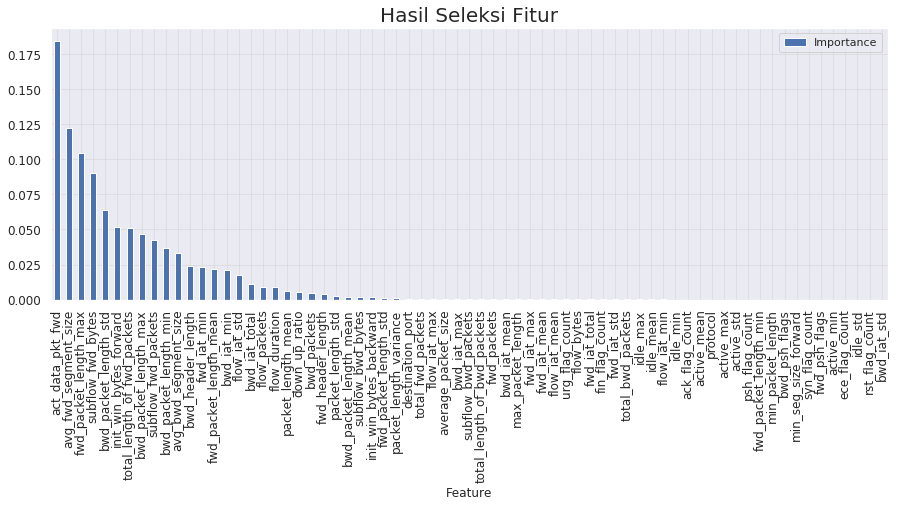

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

rfc.fit(X_ros, y_ros);

score = np.round(rfc.feature_importances_, 5)
importances = pd.DataFrame({'Feature': traincols, 'Importance': score})
importances = importances.sort_values('Importance', ascending = False).set_index('Feature')

fsplot = importances.plot(kind = 'bar', figsize = (15,5))
fsplot.set_title('Hasil Seleksi Fitur', fontsize = 20)
fsplot.grid(color = 'lightgray', alpha = 0.5)

In [0]:
fs_score = "\n".join("{} = {}".format(x, y) for x, y in sorted(zip(score,traincols)))
print(fs_score)

0.0 = active_min
0.0 = bwd_iat_std
0.0 = bwd_psh_flags
0.0 = ece_flag_count
0.0 = fwd_psh_flags
0.0 = idle_std
0.0 = min_seg_size_forward
0.0 = rst_flag_count
0.0 = syn_flag_count
1e-05 = active_max
1e-05 = active_std
1e-05 = fwd_packet_length_min
1e-05 = min_packet_length
1e-05 = psh_flag_count
3e-05 = ack_flag_count
3e-05 = active_mean
3e-05 = idle_min
3e-05 = protocol
4e-05 = flow_iat_min
4e-05 = idle_mean
6e-05 = idle_max
7e-05 = fwd_iat_std
7e-05 = total_bwd_packets
8e-05 = fin_flag_count
8e-05 = flow_bytes
8e-05 = fwd_iat_total
8e-05 = urg_flag_count
0.0001 = flow_iat_mean
0.00011 = fwd_iat_mean
0.00013 = fwd_iat_max
0.00013 = max_packet_length
0.00015 = bwd_iat_mean
0.00017 = fwd_packets
0.00019 = total_length_of_bwd_packets
0.0002 = subflow_bwd_packets
0.00023 = bwd_iat_max
0.00038 = average_packet_size
0.00044 = flow_iat_max
0.00048 = total_fwd_packets
0.00066 = destination_port
0.00077 = packet_length_variance
0.00098 = fwd_packet_length_std
0.00179 = init_win_bytes_backward


In [0]:
from sklearn.feature_selection import SelectFromModel
import itertools

sfm = SelectFromModel(rfc, threshold = 'mean')
sfm = sfm.fit(X_ros, y_ros)

feature_map = [(i, j) for i, j in itertools.zip_longest(sfm.get_support(), traincols)]
selected_features = [j for i, j in feature_map if i == True] 

In [0]:
selected_features

['destination_port',
 'total_fwd_packets',
 'total_length_of_fwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_mean',
 'bwd_packet_length_max',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'fwd_iat_mean',
 'fwd_iat_std',
 'bwd_header_length',
 'packet_length_variance',
 'average_packet_size',
 'avg_fwd_segment_size',
 'subflow_fwd_packets',
 'subflow_fwd_bytes',
 'subflow_bwd_packets',
 'init_win_bytes_forward',
 'init_win_bytes_backward',
 'act_data_pkt_fwd']

### Partisi Data

In [0]:
fullcols = list(traincols)
fullcols.append('label')

X_ros_df = pd.DataFrame(X_ros)
y_ros_df = pd.DataFrame(y_ros)

traindf = pd.concat([X_ros_df, y_ros_df], axis = 1)
traindf.columns = fullcols

testdf = pd.concat([sc_dftest, en_ytest], axis = 1)
testdf.columns = fullcols

print(traindf.shape)
print(testdf.shape)

(256054, 70)
(5926, 70)


In [0]:
X_train = traindf[traincols].values
X_test = testdf[traincols].values

X_train_fs = traindf[selected_features].values
X_test_fs = testdf[selected_features].values

ytrain = traindf[['label']].copy()
#y_train = ytrain.values
r, c = ytrain.values.shape
y_train = ytrain.values.reshape(r,)
y_train = y_train.astype(np.int64)

ytest = testdf[['label']].copy()
#y_test = ytest.values
r, c = ytest.values.shape
y_test = ytest.values.reshape(r,)
y_test = y_test.astype(np.int64)

In [0]:
X_train.shape

(256054, 69)

In [0]:
X_train_fs.shape

(256054, 20)

In [0]:
X_test.shape

(5926, 69)

In [0]:
X_test_fs.shape

(5926, 20)

In [0]:
y_train.shape

(256054,)

In [0]:
y_test.shape

(5926,)

## Pelatihan dan Pengujian dengan Fitur Lengkap

In [0]:
class grnn(object):
    def __init__(self):
        self.L2 = []
        print('Empty GRNN created.')
    
    def rbf(self, centre, x, sigma):
        #centre = centre.reshape(1,-1)
        temp = -np.sum((centre - x) ** 2, axis = 1)
        temp = temp / (2 * (sigma ** 2))
        temp = np.exp(temp)
        gaussian = np.sum(temp)
        return gaussian

    def train(self, X, y, p):
        self.num_train = X.shape[0]
        #self.num_feature = X.shape[1]
        self.num_class = p
        #labels = np.unique(y)
        #num_class = len(labels)
        for i in range(self.num_class):
            #self.L2.append([])
            indices = np.where(y == i)
            self.L2.append(X[indices,:])
        #for j in range(self.num_train):
            #self.L2[y[j]].append(X[j])
        self.L2 = np.array(self.L2)
        print('GRNN with %d classes trained.' % self.num_class)
    
    def predict(self, X, sigma):
        self.num_test = X.shape[0]
        self.L3 = np.zeros(self.num_class)
        self.L4 = np.zeros(self.num_test)
        self.sig = sigma
        for i in range(self.num_test):
            for j in range(self.num_class):
                self.L3[j] = np.sum(self.rbf(X[i], self.L2[j][0], self.sig)) / self.L2[j][0].shape[0]
                #for ji in range(len(self.L2[j])):
                    #self.L3[j] += self.rbf(X[i], self.L2[j][ji], self.sig)
                #self.L3[j] /= len(self.L2[j])
            self.L4[i] = np.argmax(self.L3)
        return self.L4
                         
    def crossValidate(self, X, y, sigma):
        result = self.predict(X, sigma)
        num_correct = sum(result == y)
        print('Cross validation accuracy with sigma %.2f: %.1f%%' % (sigma, num_correct/len(y) * 100))

In [0]:
grnn = grnn()

Empty GRNN created.


In [0]:
grnn.train(X_train, y_train, 2)

GRNN with 2 classes trained.


In [0]:
s = 0
sigma = []
accuracy = []

while s <= 1.5:
    s += 0.1
    result = grnn.predict(X_test, s)
    num_correct = sum(result == y_test)
    score = num_correct / len(y_test) * 100
    sigma.append(s)
    accuracy.append(score)
    print('Cross Validation accuracy with sigma %.2f: %.1f%%' % (s, score))
#print("The best sigma: ", max(sigma)," with accuracy: ", max(accuracy))

Cross Validation accuracy with sigma 0.10: 45.8%
Cross Validation accuracy with sigma 0.20: 28.9%
Cross Validation accuracy with sigma 0.30: 29.8%
Cross Validation accuracy with sigma 0.40: 27.4%
Cross Validation accuracy with sigma 0.50: 26.2%
Cross Validation accuracy with sigma 0.60: 26.2%
Cross Validation accuracy with sigma 0.70: 18.5%
Cross Validation accuracy with sigma 0.80: 18.1%
Cross Validation accuracy with sigma 0.90: 18.0%
Cross Validation accuracy with sigma 1.00: 66.4%
Cross Validation accuracy with sigma 1.10: 66.3%
Cross Validation accuracy with sigma 1.20: 64.8%
Cross Validation accuracy with sigma 1.30: 64.0%
Cross Validation accuracy with sigma 1.40: 64.1%
Cross Validation accuracy with sigma 1.50: 63.9%


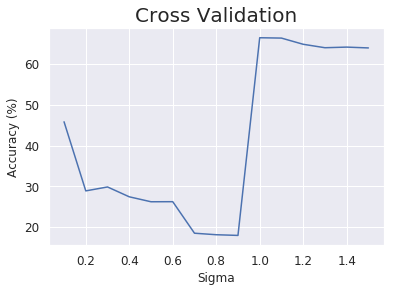

In [0]:
plt.title('Cross Validation', fontsize = 20)
plt.plot(sigma,accuracy)
plt.xlabel('Sigma')
plt.ylabel('Accuracy (%)')
plt.grid(linestyle = '-', linewidth = 1)
plt.rcParams["figure.figsize"] = [8,5]
plt.show()

In [0]:
predictions = grnn.predict(X_test, sigma=1)
print(predictions)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.

In [0]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_test, predictions)
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
classification = metrics.classification_report(y_test, predictions)
print()
print('========================= GRNN Model Test Result =========================')
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()


========================= GRNN Model Test Result =========================

Model Accuracy:
 0.6641916976037799

Confusion matrix:
 [[ 947 1832]
 [ 158 2989]]

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.34      0.49      2779
           1       0.62      0.95      0.75      3147

    accuracy                           0.66      5926
   macro avg       0.74      0.65      0.62      5926
weighted avg       0.73      0.66      0.63      5926




In [0]:
print ("Precision:" "\n", metrics.precision_score(y_test, predictions, average = 'macro'))
print()
print("Recall:" "\n", metrics.recall_score(y_test, predictions, average = 'macro'))
print()
print("F1-Score:" "\n", metrics.f1_score(y_test, predictions, average = 'macro')) 

Precision:
 0.738504713071864

Recall:
 0.6452817576281689

F1-Score:
 0.6189463053036036


## Pelatihan dan Pengujian dengan Fitur Terpilih

In [0]:
class grnn2(object):
    def __init__(self):
        self.L2 = []
        print('Empty GRNN created.')
    
    def rbf(self, centre, x, sigma):
        #centre = centre.reshape(1,-1)
        temp = -np.sum((centre - x) ** 2, axis = 1)
        temp = temp / (2 * (sigma ** 2))
        temp = np.exp(temp)
        gaussian = np.sum(temp)
        return gaussian

    def train(self, X, y, p):
        self.num_train = X.shape[0]
        #self.num_feature = X.shape[1]
        self.num_class = p
        #labels = np.unique(y)
        #num_class = len(labels)
        for i in range(self.num_class):
            #self.L2.append([])
            indices = np.where(y == i)
            self.L2.append(X[indices,:])
        #for j in range(self.num_train):
            #self.L2[y[j]].append(X[j])
        self.L2 = np.array(self.L2)
        print('GRNN with %d classes trained.' % self.num_class)
    
    def predict(self, X, sigma):
        self.num_test = X.shape[0]
        self.L3 = np.zeros(self.num_class)
        self.L4 = np.zeros(self.num_test)
        self.sig = sigma
        for i in range(self.num_test):
            for j in range(self.num_class):
                self.L3[j] = np.sum(self.rbf(X[i], self.L2[j][0], self.sig)) / self.L2[j][0].shape[0]
                #for ji in range(len(self.L2[j])):
                    #self.L3[j] += self.rbf(X[i], self.L2[j][ji], self.sig)
                #self.L3[j] /= len(self.L2[j])
            self.L4[i] = np.argmax(self.L3)
        return self.L4
                         
    def crossValidate(self, X, y, sigma):
        result = self.predict(X, sigma)
        num_correct = sum(result == y)
        print('Cross validation accuracy with sigma %.2f: %.1f%%' % (sigma, num_correct/len(y) * 100))

In [0]:
grnn2 = grnn2()

Empty GRNN created.


In [0]:
grnn2.train(X_train_fs, y_train, p=2)

GRNN with 2 classes trained.


In [0]:
s2 = 0
sigma2 = []
accuracy2 = []

while s2 <= 1.5:
    s2 += 0.1
    result2 = grnn2.predict(X_test_fs, s2)
    num_correct2 = sum(result2 == y_test)
    score2 = num_correct2 / len(y_test) * 100
    sigma2.append(s2)
    accuracy2.append(score2)
    print('Cross Validation accuracy with sigma %.2f: %.1f%%' % (s2, score2))
#print("The best sigma: ", max(sigma)," with accuracy: ", max(accuracy))

Cross Validation accuracy with sigma 0.10: 46.9%
Cross Validation accuracy with sigma 0.20: 47.2%
Cross Validation accuracy with sigma 0.30: 47.1%
Cross Validation accuracy with sigma 0.40: 47.1%
Cross Validation accuracy with sigma 0.50: 47.2%
Cross Validation accuracy with sigma 0.60: 48.1%
Cross Validation accuracy with sigma 0.70: 48.3%
Cross Validation accuracy with sigma 0.80: 48.2%
Cross Validation accuracy with sigma 0.90: 48.2%
Cross Validation accuracy with sigma 1.00: 97.2%
Cross Validation accuracy with sigma 1.10: 97.1%
Cross Validation accuracy with sigma 1.20: 97.1%
Cross Validation accuracy with sigma 1.30: 97.0%
Cross Validation accuracy with sigma 1.40: 97.0%
Cross Validation accuracy with sigma 1.50: 97.0%


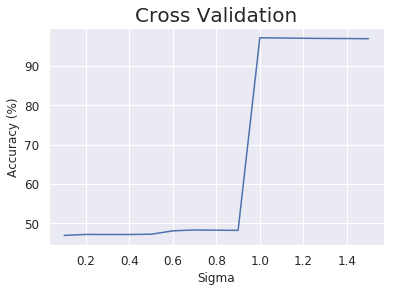

In [0]:
plt.title('Cross Validation', fontsize = 20)
plt.plot(sigma2,accuracy2)
plt.xlabel('Sigma')
plt.ylabel('Accuracy (%)')
plt.grid(linestyle = '-', linewidth = 1)
plt.rcParams["figure.figsize"] = [8,5]
plt.show()

In [0]:
predictions2 = grnn2.predict(X_test_fs, sigma=1)
print(predictions2)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [0]:
import sklearn.metrics as metrics

accuracy2 = metrics.accuracy_score(y_test, predictions2)
confusion_matrix2 = metrics.confusion_matrix(y_test, predictions2)
classification2 = metrics.classification_report(y_test, predictions2)
print()
print('========================= GRNN Model Test Result =========================')
print()
print ("Model Accuracy:" "\n", accuracy2)
print()
print("Confusion matrix:" "\n", confusion_matrix2)
print()
print("Classification report:" "\n", classification2) 
print()


========================= GRNN Model Test Result =========================

Model Accuracy:
 0.9721565980425245

Confusion matrix:
 [[2690   89]
 [  76 3071]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2779
           1       0.97      0.98      0.97      3147

    accuracy                           0.97      5926
   macro avg       0.97      0.97      0.97      5926
weighted avg       0.97      0.97      0.97      5926




In [0]:
print ("Precision:" "\n", metrics.precision_score(y_test, predictions2, average = 'macro'))
print()
print("Recall:" "\n", metrics.recall_score(y_test, predictions2, average = 'macro'))
print()
print("F1-Score:" "\n", metrics.f1_score(y_test, predictions2, average = 'macro')) 

Precision:
 0.9721794713382208

Recall:
 0.9719120536439658

F1-Score:
 0.9720410273097448
